In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

### Define transform

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

### Download data and define dataloaders

In [9]:
from torchvision import datasets, transforms
datasets.MNIST.resources = [
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
]

data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)





In [12]:
#Define train and validation sizes
train_size = int(0.8*len(data))
val_size = int(0.2*len(data))
print(train_size)
print(val_size)

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

#Make dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

48000
12000


### Print examples from dataset

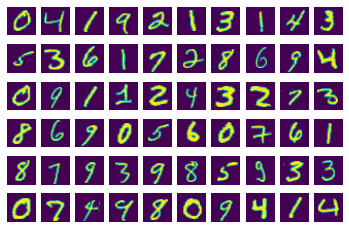

In [30]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(data[index][0].numpy().squeeze())

## Create CNN

In [40]:
class cnn_model(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(cnn_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2,padding=2),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Check CUDA and set hyper parameters

In [52]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
cnn = cnn_model(num_classes=10)
cnn.to(device)

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

epochs = 50

### pray that we not run into OOM error

In [53]:
import gc
torch.cuda.empty_cache()
#del variables
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  501577 KB |    6470 MB |   12333 GB |   12333 GB |\n|       from large pool |  497664 KB |    1602 MB |   11868 GB |   11868 GB |\n|       from small pool |    3913 KB |    4996 MB |     465 GB |     465 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  501577 KB |    6470 MB |   12333 GB |   12333 GB |\n|       from large pool |  497664 KB |    1602 MB |

In [54]:
# set writer for tensorboard
writer = SummaryWriter()
epoch_data = []
train_epoch = []
val_epoch = []
for epoch in range(epochs):  # loop over the dataset multiple times
    epoch_data.append(epoch + 1)
    running_loss = 0.0
    running_loss_val = 0.0
    for i, data in enumerate(trainloader, 0):
        print('\rProgress for training: [{}/{}] Epoch progrss: [{}/{}]'.format(epoch+1, epochs, i+1, len(trainloader)), end='', flush=True)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = cnn(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        writer.add_scalar("Loss/train_pretrained", loss, epoch)
        # print statistics
        running_loss += loss.item() / len(trainloader)
    for i, data in enumerate(val_loader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward only
        output = cnn(inputs)
        loss = criterion(output, labels)

        # print statistics
        running_loss_val += loss.item() / len(val_loader)
    train_epoch.append(running_loss)
    val_epoch.append(running_loss_val)
    

print('Finished Training of CNN')
writer.flush()
writer.close()

Progress for training: [50/50] Epoch progrss: [12000/12000]Finished Training of CNN


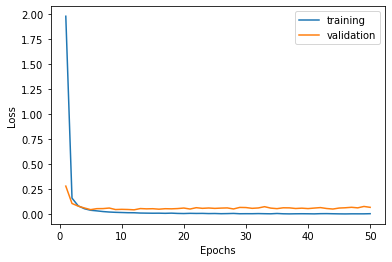

In [55]:
plt.plot(range(1,epochs+1), train_epoch,label='training')
plt.plot(range(1,epochs+1),val_epoch, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        print('\rEpoch progrss: [{}/{}]'.format(i+1, len(testloader)), end='', flush=True)

        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('\nAccuracy of the network on the test images: {}%'.format(
    100.0 * correct / total))

Epoch progrss: [2500/2500]
Accuracy of the network on the test images: 99.04%


In [60]:
torch.save(cnn.state_dict(), "myCNN") # Feature extraction